In [77]:
import pandas as pd
import numpy as np
from transpa.util import compute_autocorr
from transpa.eval_util import calc_corr
from scipy.spatial.distance import cosine 
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from scipy.stats.mstats import gmean
import scanpy as sc
import squidpy as sq
import pickle

ST_names = ["melanoma5fold", "mouseliver5fold", "intestine5fold", "breastcancer5fold"]
methods = ["TransImp", "TransImpSpa", "TransImpCls", "TransImpClsSpa", "spaGE", "stPlus", "Tangram", "truth"]

In [2]:
pd.read_csv(f'../../output/{ST_names[0]}_{ST_names[0]}_{methods[0]}.csv', index_col=0, header=0)

,A1BG,A2M,A4GALT,AAED1,AAK1,AARS2,AARSD1,AASS,AATF,ABCA10,...,ZRANB3,ZSCAN1,ZSCAN16,ZSCAN18,ZSCAN30,ZSCAN5A,ZSWIM5,ZSWIM6,ZSWIM7,ZUFSP
0,0.305361,2.113123,0.039536,0.147101,0.834189,1.064202,0.863632,0.768801,1.224289,0.055305,...,0.130655,0.007353,0.316749,0.114931,0.305700,0.032456,0.061689,0.169906,0.987529,0.303991
1,0.282346,1.684600,0.045197,0.131758,0.915609,1.015807,0.737953,0.704811,1.081929,0.052396,...,0.107006,0.007959,0.272057,0.104078,0.272999,0.039887,0.064265,0.150097,0.843506,0.228996
2,0.251644,1.778849,0.058061,0.116561,0.819253,1.017998,0.756551,0.677366,1.001005,0.059175,...,0.122590,0.005208,0.261049,0.113979,0.288227,0.035955,0.061760,0.139461,0.928122,0.252206
3,0.268182,1.907462,0.043691,0.118540,0.805060,0.955585,0.754329,0.686552,1.067442,0.040889,...,0.104847,0.008201,0.223318,0.101027,0.244616,0.048018,0.064573,0.141248,0.829640,0.256090
4,0.278773,1.719027,0.039266,0.122321,0.861148,1.044666,0.741616,0.725172,1.035272,0.054798,...,0.133377,0.008161,0.305503,0.114442,0.268963,0.046105,0.059329,0.160986,0.953546,0.254534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288,0.275294,1.835761,0.047921,0.120917,0.928227,1.037547,0.734582,0.743573,1.067489,0.058692,...,0.122746,0.002475,0.270135,0.100536,0.267825,0.051606,0.061334,0.153280,0.891927,0.256102
289,0.254465,1.826183,0.055200,0.117216,0.828635,0.933276,0.702883,0.644927,1.043701,0.050361,...,0.108420,0.006178,0.260807,0.099496,0.263031,0.043132,0.060550,0.152530,0.872800,0.245478
290,0.264999,1.736031,0.071430,0.095105,0.980074,1.092019,0.758927,0.699329,1.119240,0.066144,...,0.112074,0.002939,0.278194,0.113575,0.280460,0.048850,0.065757,0.135031,0.885398,0.291003
291,0.271512,1.592910,0.082522,0.125009,1.162351,1.253324,0.801931,0.741724,1.216110,0.075940,...,0.138584,0.007718,0.345885,0.142661,0.317877,0.057606,0.079088,0.163823,1.101000,0.320159


False

In [56]:
def cmp_scores(ST_name, thred_cos=0.2, thred_mseI=0.1, thred_fdr=0.01):
    dict_df = {method: pd.read_csv(f'../../output/{ST_name}_{ST_name}_{method}.csv', index_col=0, header=0) for method in methods}

    with open(f"../../output/{ST_name}ext_small_train_eval_results.pkl", 'rb') as infile:
        eval_res, spa_adata, dict_adata = pickle.load(infile)

    with open(f"../../output/{ST_name}_spatialdm.pkl", 'rb') as infile:
        m_adatas = pickle.load(infile)

    df_se_moranI = pd.DataFrame(dict(sorted(eval_res['se_moranI'].items())))
    df_corr      = pd.DataFrame(dict(sorted(eval_res['pred_corr'].items())))
    df_fdr     = pd.DataFrame(dict(sorted(eval_res['fdr'].items())))
    df_pval     = pd.DataFrame(dict(sorted(eval_res['pval'].items())))
    df_I     = pd.DataFrame(dict(sorted(eval_res['I'].items())))
    df_fdr['truth'] = spa_adata.uns['moranI'].loc[df_fdr.index.values,:].pval_norm_fdr_bh
    df_I['truth'] = spa_adata.uns['moranI'].loc[df_fdr.index.values,:].I
    df_pval['truth'] = spa_adata.uns['moranI'].loc[df_pval.index.values,:].pval_norm

    dict_sparkx_cmbpvals = {}
    dict_sparkx_adjpvals = {}
    ca_genes = None

    for md in methods:
        df = pd.read_csv(f"../../output/sparkx_{ST_name}_{md}.csv", header=0, index_col=0)
        if ca_genes is None:
            ca_genes = df.index.values
        
        shared_gene = np.intersect1d(ca_genes, df.index.values)
        if len(shared_gene) < len(ca_genes):
            miss_gene  = np.setdiff1d(ca_genes, shared_gene)
            df = pd.concat([df, pd.DataFrame({"combinedPval":{g:1.0 for g in miss_gene},"adjustedPval":{g:1.0 for g in miss_gene} })], axis=0)
        dict_sparkx_cmbpvals[md] = df.loc[ca_genes, 'combinedPval']
        dict_sparkx_adjpvals[md] = df.loc[ca_genes, 'adjustedPval']
    df_sparkx_cmbpvals = pd.DataFrame(dict_sparkx_cmbpvals)
    df_sparkx_adjpvals = pd.DataFrame(dict_sparkx_adjpvals)  

    method_moranI = {f"{ST_name}_mse_moranI":{}}
    method_cos = {f"{ST_name}_cos_corr":{}}
    method_thred_prop = {f"{ST_name}_cos_thred{thred_cos}":{}}
    method_meanprecision_moranI = {f"{ST_name}_mean_prec_moranI":{}}
    method_meanprecision_sparkx = {f"{ST_name}_mean_prec_sparkx":{}}
    method_meanprecision_spatialdm = {f"{ST_name}_mean_prec_spatialdm":{}}
    
    for method in dict_df:
        # corrs = np.array(calc_corr(dict_df['truth'], dict_df[method], dict_df['truth'].columns, False))\
        corrs = []
        for gene in dict_df['truth'].columns:
            u, v = dict_df['truth'][gene].values, dict_df[method][gene].values
            if (v != 0).sum() == 0:
                corrs.append(np.nan)
            else:
                corrs.append(1 - cosine(u, v))
        corrs = np.array(corrs)
        np.nan_to_num(corrs, copy=False, nan=-1)
        print(np.median(corrs), np.median(corrs[corrs > thred_cos] ))
        # plt.hist(corrs); plt.title(f"{method}: {(corrs > thred).sum()/len(corrs):.1%}") ;plt.show()
        mse_moranI = (dict_adata[method].uns['moranI'].I.values - dict_adata["truth"].uns['moranI'].I.values)**2

        sel = (~np.isnan(df_I['truth'].values) ) # & (~np.isnan(df_I[method].values))
        sel = sel & (df_I.truth.values >= 0)
        truth_pval, preds_pval = df_fdr.truth.values[sel], df_fdr[method][sel]
        np.nan_to_num(df_I[method].values, copy=False, nan=-1)
        score = df_I[method][sel]
        print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}, Ground Sig/Total ({(truth_pval < thred_fdr).sum()}/{truth_pval.shape[0]}), Pred Sig/total ({(preds_pval < thred_fdr).sum()}/{preds_pval.shape[0]})')

        method_cos[f"{ST_name}_cos_corr"][method] = np.median(corrs)
        method_thred_prop[f"{ST_name}_cos_gt{thred_cos}_ratio"][method] = (corrs > thred_cos).sum()/len(corrs)
        method_moranI[f"{ST_name}_mse_moranI_st{thred_mseI}_ratio"][method] = (mse_moranI < thred_mseI).sum() / len(mse_moranI)
        method_meanprecision_moranI[f"{ST_name}_mean_prec_moranI"][method] = metrics.average_precision_score(truth_pval < thred_fdr, score)

        sel = (~np.isnan(df_sparkx_adjpvals['truth'].values) ) & (~np.isnan(df_sparkx_adjpvals[method].values))
        print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
        truth_pval, method_pval = df_sparkx_adjpvals.truth.values[sel], df_sparkx_adjpvals[method][sel]
        score = -np.log(df_sparkx_adjpvals[method][sel].values + min(np.min(df_sparkx_adjpvals[method][sel].values) * 1e-3, 1e-500))
        method_meanprecision_sparkx[f"{ST_name}_mean_prec_sparkx"][method] = metrics.average_precision_score(truth_pval < thred_fdr, score)


        truth_res = m_adatas['truth'].uns['global_res'].loc[m_adatas['truth'].uns['global_I'] >= 0].copy()
        genes = np.intersect1d(truth_res.index, m_adatas[method].uns['global_res'].index)
        print(f"{method} # {len(genes)} pairs, # sig pairs: (Truth): {truth_res.loc[genes].selected.values.sum()}, (Preds) {m_adatas[method].uns['global_res'].loc[genes].selected.values.sum()}")
        if len(genes) < len(truth_res.index):
            print(f"{method} Fewer genes than truth: {len(genes)} vs {len(truth_res.index)}")
        y = truth_res.loc[genes].selected.values
       
        score =  - np.log(m_adatas[method].uns['global_res'].loc[genes].fdr.values + min(np.min(m_adatas[method].uns['global_res'].loc[genes].fdr.values)/1000, 1e-500))
        score[np.isinf(score)] = score[~np.isinf(score)].max()*10
        method_meanprecision_spatialdm[f"{ST_name}_mean_prec_spatialdm"][method] = metrics.average_precision_score(y, score)

    return method_thred_prop, method_moranI, method_meanprecision_moranI, method_meanprecision_sparkx, method_meanprecision_spatialdm

cmp_scores(ST_names[2], 0.2, 0.05, 0.01)

0.2623082110140132 0.37423798166517075
(TransImp) Valid genes: 5512/6852, Ground Sig/Total (3634/5512), Pred Sig/total (5512/5512)
(TransImp) Valid genes: 6852/6852
TransImp # 1396 pairs, # sig pairs: (Truth): 282, (Preds) 697


/tmp/ipykernel_3856029/3250276932.py:85: RuntimeWarning: divide by zero encountered in log
  score =  - np.log(m_adatas[method].uns['global_res'].loc[genes].fdr.values + min(np.min(m_adatas[method].uns['global_res'].loc[genes].fdr.values)/1000, 1e-500))


0.24775734213222822 0.3649158669679707
(TransImpSpa) Valid genes: 5512/6852, Ground Sig/Total (3634/5512), Pred Sig/total (3693/5512)
(TransImpSpa) Valid genes: 6852/6852
TransImpSpa # 1396 pairs, # sig pairs: (Truth): 282, (Preds) 524


/tmp/ipykernel_3856029/3250276932.py:85: RuntimeWarning: divide by zero encountered in log
  score =  - np.log(m_adatas[method].uns['global_res'].loc[genes].fdr.values + min(np.min(m_adatas[method].uns['global_res'].loc[genes].fdr.values)/1000, 1e-500))


0.272269068223871 0.38058884824848005
(TransImpCls) Valid genes: 5512/6852, Ground Sig/Total (3634/5512), Pred Sig/total (5512/5512)
(TransImpCls) Valid genes: 6852/6852
TransImpCls # 1396 pairs, # sig pairs: (Truth): 282, (Preds) 511


/tmp/ipykernel_3856029/3250276932.py:85: RuntimeWarning: divide by zero encountered in log
  score =  - np.log(m_adatas[method].uns['global_res'].loc[genes].fdr.values + min(np.min(m_adatas[method].uns['global_res'].loc[genes].fdr.values)/1000, 1e-500))


0.2646769761742365 0.3757607821363491
(TransImpClsSpa) Valid genes: 5512/6852, Ground Sig/Total (3634/5512), Pred Sig/total (4968/5512)
(TransImpClsSpa) Valid genes: 6852/6852
TransImpClsSpa # 1396 pairs, # sig pairs: (Truth): 282, (Preds) 523


/tmp/ipykernel_3856029/3250276932.py:85: RuntimeWarning: divide by zero encountered in log
  score =  - np.log(m_adatas[method].uns['global_res'].loc[genes].fdr.values + min(np.min(m_adatas[method].uns['global_res'].loc[genes].fdr.values)/1000, 1e-500))


0.24722226036086875 0.392472642895636
(spaGE) Valid genes: 5512/6852, Ground Sig/Total (3634/5512), Pred Sig/total (5437/5512)
(spaGE) Valid genes: 6852/6852
spaGE # 1396 pairs, # sig pairs: (Truth): 282, (Preds) 384


/tmp/ipykernel_3856029/3250276932.py:85: RuntimeWarning: divide by zero encountered in log
  score =  - np.log(m_adatas[method].uns['global_res'].loc[genes].fdr.values + min(np.min(m_adatas[method].uns['global_res'].loc[genes].fdr.values)/1000, 1e-500))


0.23084359420638206 0.3919398241162325
(stPlus) Valid genes: 5512/6852, Ground Sig/Total (3634/5512), Pred Sig/total (0/5512)
(stPlus) Valid genes: 6852/6852
stPlus # 1396 pairs, # sig pairs: (Truth): 282, (Preds) 313


/tmp/ipykernel_3856029/3250276932.py:85: RuntimeWarning: divide by zero encountered in log
  score =  - np.log(m_adatas[method].uns['global_res'].loc[genes].fdr.values + min(np.min(m_adatas[method].uns['global_res'].loc[genes].fdr.values)/1000, 1e-500))


0.2696443713393144 0.38052231718122176
(Tangram) Valid genes: 5512/6852, Ground Sig/Total (3634/5512), Pred Sig/total (5512/5512)
(Tangram) Valid genes: 6852/6852
Tangram # 1396 pairs, # sig pairs: (Truth): 282, (Preds) 659


/tmp/ipykernel_3856029/3250276932.py:85: RuntimeWarning: divide by zero encountered in log
  score =  - np.log(m_adatas[method].uns['global_res'].loc[genes].fdr.values + min(np.min(m_adatas[method].uns['global_res'].loc[genes].fdr.values)/1000, 1e-500))


1.0 1.0
(truth) Valid genes: 5512/6852, Ground Sig/Total (3634/5512), Pred Sig/total (3634/5512)
(truth) Valid genes: 6852/6852
truth # 1396 pairs, # sig pairs: (Truth): 282, (Preds) 282


({'intestine5fold_cos_thred0.2': {'TransImp': 0.6466725043782837,
   'TransImpSpa': 0.6161704611792177,
   'TransImpCls': 0.6636018680677175,
   'TransImpClsSpa': 0.6468184471687098,
   'spaGE': 0.5926736719206072,
   'stPlus': 0.5583771161704612,
   'Tangram': 0.6609748978400467,
   'truth': 1.0}},
 {'intestine5fold_mse_moranI': {'TransImp': 0.005837711617046118,
   'TransImpSpa': 0.9989784004670169,
   'TransImpCls': 0.0021891418563922942,
   'TransImpClsSpa': 0.993286631640397,
   'spaGE': 0.3023934617629889,
   'stPlus': 0.20417396380618796,
   'Tangram': 0.010945709281961471,
   'truth': 1.0}},
 {'intestine5fold_mean_prec_moranI': {'TransImp': 0.774596786805726,
   'TransImpSpa': 0.8417890916665667,
   'TransImpCls': 0.7475130293322029,
   'TransImpClsSpa': 0.7852071537084011,
   'spaGE': 0.8401707620455297,
   'stPlus': 0.806822711236339,
   'Tangram': 0.7640353499618445,
   'truth': 1.0}},
 {'intestine5fold_mean_prec_sparkx': {'TransImp': 0.5965574056626852,
   'TransImpSpa': 0.

In [57]:
res_cos_gt0_2_ratio = {}
res_mse_moranI_st0_05_ratio = {}
res_mean_prec_HVG_moranI = {}
res_mean_prec_HVG_sparkx = {}
res_mean_prec_LR_spatialdm = {}

for ST_name in ST_names:
    _cos_rt, _mse_I, _HVG_I, _HVG_sparkx, _LR_spatialDM = cmp_scores(ST_name,  0.2, 0.05, 0.01)
    res_cos_gt0_2_ratio.update(_cos_rt)
    res_mse_moranI_st0_05_ratio.update(_mse_I)
    res_mean_prec_HVG_moranI.update(_HVG_I)
    res_mean_prec_HVG_sparkx.update(_HVG_sparkx)
    res_mean_prec_LR_spatialdm.update(_LR_spatialDM)

0.2889110861899328 0.34910564844953684
(TransImp) Valid genes: 2681/5380, Ground Sig/Total (759/2681), Pred Sig/total (2649/2681)
(TransImp) Valid genes: 5380/5380
TransImp # 567 pairs, # sig pairs: (Truth): 142, (Preds) 386


/tmp/ipykernel_3856029/3250276932.py:85: RuntimeWarning: divide by zero encountered in log
  score =  - np.log(m_adatas[method].uns['global_res'].loc[genes].fdr.values + min(np.min(m_adatas[method].uns['global_res'].loc[genes].fdr.values)/1000, 1e-500))


0.2804834101422747 0.34164405004163845
(TransImpSpa) Valid genes: 2681/5380, Ground Sig/Total (759/2681), Pred Sig/total (339/2681)
(TransImpSpa) Valid genes: 5380/5380
TransImpSpa # 567 pairs, # sig pairs: (Truth): 142, (Preds) 329
0.29389801282152267 0.35525964168860535
(TransImpCls) Valid genes: 2681/5380, Ground Sig/Total (759/2681), Pred Sig/total (2665/2681)
(TransImpCls) Valid genes: 5380/5380
TransImpCls # 567 pairs, # sig pairs: (Truth): 142, (Preds) 366
0.2899775283925403 0.35146312440458904
(TransImpClsSpa) Valid genes: 2681/5380, Ground Sig/Total (759/2681), Pred Sig/total (0/2681)
(TransImpClsSpa) Valid genes: 5380/5380
TransImpClsSpa # 567 pairs, # sig pairs: (Truth): 142, (Preds) 377
0.26482386031649885 0.34854492602341436
(spaGE) Valid genes: 2681/5380, Ground Sig/Total (759/2681), Pred Sig/total (2449/2681)
(spaGE) Valid genes: 5380/5380
spaGE # 567 pairs, # sig pairs: (Truth): 142, (Preds) 367
0.26241601758160715 0.3476984974087641
(stPlus) Valid genes: 2681/5380, Gro

/tmp/ipykernel_3856029/3250276932.py:85: RuntimeWarning: divide by zero encountered in log
  score =  - np.log(m_adatas[method].uns['global_res'].loc[genes].fdr.values + min(np.min(m_adatas[method].uns['global_res'].loc[genes].fdr.values)/1000, 1e-500))


0.29086393495473967 0.35213709546293437
(Tangram) Valid genes: 2681/5380, Ground Sig/Total (759/2681), Pred Sig/total (2654/2681)
(Tangram) Valid genes: 5380/5380
Tangram # 567 pairs, # sig pairs: (Truth): 142, (Preds) 364
1.0 1.0
(truth) Valid genes: 2681/5380, Ground Sig/Total (759/2681), Pred Sig/total (759/2681)
(truth) Valid genes: 5380/5380
truth # 567 pairs, # sig pairs: (Truth): 142, (Preds) 142
0.5056531917123063 0.5560000162882542
(TransImp) Valid genes: 3546/4517, Ground Sig/Total (808/3546), Pred Sig/total (3343/3546)
(TransImp) Valid genes: 4517/4517
TransImp # 262 pairs, # sig pairs: (Truth): 24, (Preds) 109


/tmp/ipykernel_3856029/3250276932.py:85: RuntimeWarning: divide by zero encountered in log
  score =  - np.log(m_adatas[method].uns['global_res'].loc[genes].fdr.values + min(np.min(m_adatas[method].uns['global_res'].loc[genes].fdr.values)/1000, 1e-500))


0.5028532328773107 0.5539842510199784
(TransImpSpa) Valid genes: 3546/4517, Ground Sig/Total (808/3546), Pred Sig/total (1837/3546)
(TransImpSpa) Valid genes: 4517/4517
TransImpSpa # 262 pairs, # sig pairs: (Truth): 24, (Preds) 102
0.5165320277175559 0.5565459210416417
(TransImpCls) Valid genes: 3546/4517, Ground Sig/Total (808/3546), Pred Sig/total (3523/3546)
(TransImpCls) Valid genes: 4517/4517
TransImpCls # 262 pairs, # sig pairs: (Truth): 24, (Preds) 112


/tmp/ipykernel_3856029/3250276932.py:85: RuntimeWarning: divide by zero encountered in log
  score =  - np.log(m_adatas[method].uns['global_res'].loc[genes].fdr.values + min(np.min(m_adatas[method].uns['global_res'].loc[genes].fdr.values)/1000, 1e-500))


0.5139833297304193 0.5547495266516855
(TransImpClsSpa) Valid genes: 3546/4517, Ground Sig/Total (808/3546), Pred Sig/total (2398/3546)
(TransImpClsSpa) Valid genes: 4517/4517
TransImpClsSpa # 262 pairs, # sig pairs: (Truth): 24, (Preds) 104
0.41112371451629903 0.4739018200216413
(spaGE) Valid genes: 3546/4517, Ground Sig/Total (808/3546), Pred Sig/total (3351/3546)
(spaGE) Valid genes: 4517/4517
spaGE # 262 pairs, # sig pairs: (Truth): 24, (Preds) 87
0.42002087797141285 0.526789097681462
(stPlus) Valid genes: 3546/4517, Ground Sig/Total (808/3546), Pred Sig/total (0/3546)
(stPlus) Valid genes: 4517/4517
stPlus # 262 pairs, # sig pairs: (Truth): 24, (Preds) 78


/tmp/ipykernel_3856029/3250276932.py:85: RuntimeWarning: divide by zero encountered in log
  score =  - np.log(m_adatas[method].uns['global_res'].loc[genes].fdr.values + min(np.min(m_adatas[method].uns['global_res'].loc[genes].fdr.values)/1000, 1e-500))


0.5134445642536275 0.5531384770301901
(Tangram) Valid genes: 3546/4517, Ground Sig/Total (808/3546), Pred Sig/total (3517/3546)
(Tangram) Valid genes: 4517/4517
Tangram # 262 pairs, # sig pairs: (Truth): 24, (Preds) 112


/tmp/ipykernel_3856029/3250276932.py:85: RuntimeWarning: divide by zero encountered in log
  score =  - np.log(m_adatas[method].uns['global_res'].loc[genes].fdr.values + min(np.min(m_adatas[method].uns['global_res'].loc[genes].fdr.values)/1000, 1e-500))


1.0 1.0
(truth) Valid genes: 3546/4517, Ground Sig/Total (808/3546), Pred Sig/total (808/3546)
(truth) Valid genes: 4517/4517
truth # 262 pairs, # sig pairs: (Truth): 24, (Preds) 24
0.2623082110140132 0.37423798166517075
(TransImp) Valid genes: 5512/6852, Ground Sig/Total (3634/5512), Pred Sig/total (5512/5512)
(TransImp) Valid genes: 6852/6852
TransImp # 1396 pairs, # sig pairs: (Truth): 282, (Preds) 697


/tmp/ipykernel_3856029/3250276932.py:85: RuntimeWarning: divide by zero encountered in log
  score =  - np.log(m_adatas[method].uns['global_res'].loc[genes].fdr.values + min(np.min(m_adatas[method].uns['global_res'].loc[genes].fdr.values)/1000, 1e-500))


0.24775734213222822 0.3649158669679707
(TransImpSpa) Valid genes: 5512/6852, Ground Sig/Total (3634/5512), Pred Sig/total (3693/5512)
(TransImpSpa) Valid genes: 6852/6852
TransImpSpa # 1396 pairs, # sig pairs: (Truth): 282, (Preds) 524


/tmp/ipykernel_3856029/3250276932.py:85: RuntimeWarning: divide by zero encountered in log
  score =  - np.log(m_adatas[method].uns['global_res'].loc[genes].fdr.values + min(np.min(m_adatas[method].uns['global_res'].loc[genes].fdr.values)/1000, 1e-500))


0.272269068223871 0.38058884824848005
(TransImpCls) Valid genes: 5512/6852, Ground Sig/Total (3634/5512), Pred Sig/total (5512/5512)
(TransImpCls) Valid genes: 6852/6852
TransImpCls # 1396 pairs, # sig pairs: (Truth): 282, (Preds) 511


/tmp/ipykernel_3856029/3250276932.py:85: RuntimeWarning: divide by zero encountered in log
  score =  - np.log(m_adatas[method].uns['global_res'].loc[genes].fdr.values + min(np.min(m_adatas[method].uns['global_res'].loc[genes].fdr.values)/1000, 1e-500))


0.2646769761742365 0.3757607821363491
(TransImpClsSpa) Valid genes: 5512/6852, Ground Sig/Total (3634/5512), Pred Sig/total (4968/5512)
(TransImpClsSpa) Valid genes: 6852/6852
TransImpClsSpa # 1396 pairs, # sig pairs: (Truth): 282, (Preds) 523


/tmp/ipykernel_3856029/3250276932.py:85: RuntimeWarning: divide by zero encountered in log
  score =  - np.log(m_adatas[method].uns['global_res'].loc[genes].fdr.values + min(np.min(m_adatas[method].uns['global_res'].loc[genes].fdr.values)/1000, 1e-500))


0.24722226036086875 0.392472642895636
(spaGE) Valid genes: 5512/6852, Ground Sig/Total (3634/5512), Pred Sig/total (5437/5512)
(spaGE) Valid genes: 6852/6852
spaGE # 1396 pairs, # sig pairs: (Truth): 282, (Preds) 384


/tmp/ipykernel_3856029/3250276932.py:85: RuntimeWarning: divide by zero encountered in log
  score =  - np.log(m_adatas[method].uns['global_res'].loc[genes].fdr.values + min(np.min(m_adatas[method].uns['global_res'].loc[genes].fdr.values)/1000, 1e-500))


0.23084359420638206 0.3919398241162325
(stPlus) Valid genes: 5512/6852, Ground Sig/Total (3634/5512), Pred Sig/total (0/5512)
(stPlus) Valid genes: 6852/6852
stPlus # 1396 pairs, # sig pairs: (Truth): 282, (Preds) 313


/tmp/ipykernel_3856029/3250276932.py:85: RuntimeWarning: divide by zero encountered in log
  score =  - np.log(m_adatas[method].uns['global_res'].loc[genes].fdr.values + min(np.min(m_adatas[method].uns['global_res'].loc[genes].fdr.values)/1000, 1e-500))


0.2696443713393144 0.38052231718122176
(Tangram) Valid genes: 5512/6852, Ground Sig/Total (3634/5512), Pred Sig/total (5512/5512)
(Tangram) Valid genes: 6852/6852
Tangram # 1396 pairs, # sig pairs: (Truth): 282, (Preds) 659


/tmp/ipykernel_3856029/3250276932.py:85: RuntimeWarning: divide by zero encountered in log
  score =  - np.log(m_adatas[method].uns['global_res'].loc[genes].fdr.values + min(np.min(m_adatas[method].uns['global_res'].loc[genes].fdr.values)/1000, 1e-500))


1.0 1.0
(truth) Valid genes: 5512/6852, Ground Sig/Total (3634/5512), Pred Sig/total (3634/5512)
(truth) Valid genes: 6852/6852
truth # 1396 pairs, # sig pairs: (Truth): 282, (Preds) 282
0.29439436894829385 0.3719223019037172
(TransImp) Valid genes: 3010/4241, Ground Sig/Total (921/3010), Pred Sig/total (2945/3010)
(TransImp) Valid genes: 4241/4241
TransImp # 829 pairs, # sig pairs: (Truth): 291, (Preds) 632


/tmp/ipykernel_3856029/3250276932.py:85: RuntimeWarning: divide by zero encountered in log
  score =  - np.log(m_adatas[method].uns['global_res'].loc[genes].fdr.values + min(np.min(m_adatas[method].uns['global_res'].loc[genes].fdr.values)/1000, 1e-500))


0.29444413029969885 0.37143426666506807
(TransImpSpa) Valid genes: 3010/4241, Ground Sig/Total (921/3010), Pred Sig/total (1748/3010)
(TransImpSpa) Valid genes: 4241/4241
TransImpSpa # 829 pairs, # sig pairs: (Truth): 291, (Preds) 608


/tmp/ipykernel_3856029/3250276932.py:85: RuntimeWarning: divide by zero encountered in log
  score =  - np.log(m_adatas[method].uns['global_res'].loc[genes].fdr.values + min(np.min(m_adatas[method].uns['global_res'].loc[genes].fdr.values)/1000, 1e-500))


0.29946108553708817 0.3739677276077519
(TransImpCls) Valid genes: 3010/4241, Ground Sig/Total (921/3010), Pred Sig/total (2997/3010)
(TransImpCls) Valid genes: 4241/4241
TransImpCls # 829 pairs, # sig pairs: (Truth): 291, (Preds) 650


/tmp/ipykernel_3856029/3250276932.py:85: RuntimeWarning: divide by zero encountered in log
  score =  - np.log(m_adatas[method].uns['global_res'].loc[genes].fdr.values + min(np.min(m_adatas[method].uns['global_res'].loc[genes].fdr.values)/1000, 1e-500))


0.2980957789695642 0.37275520025650155
(TransImpClsSpa) Valid genes: 3010/4241, Ground Sig/Total (921/3010), Pred Sig/total (1708/3010)
(TransImpClsSpa) Valid genes: 4241/4241
TransImpClsSpa # 829 pairs, # sig pairs: (Truth): 291, (Preds) 632


/tmp/ipykernel_3856029/3250276932.py:85: RuntimeWarning: divide by zero encountered in log
  score =  - np.log(m_adatas[method].uns['global_res'].loc[genes].fdr.values + min(np.min(m_adatas[method].uns['global_res'].loc[genes].fdr.values)/1000, 1e-500))


0.24965596164966652 0.35332710184255856
(spaGE) Valid genes: 3010/4241, Ground Sig/Total (921/3010), Pred Sig/total (2479/3010)
(spaGE) Valid genes: 4241/4241
spaGE # 829 pairs, # sig pairs: (Truth): 291, (Preds) 470


/tmp/ipykernel_3856029/3250276932.py:85: RuntimeWarning: divide by zero encountered in log
  score =  - np.log(m_adatas[method].uns['global_res'].loc[genes].fdr.values + min(np.min(m_adatas[method].uns['global_res'].loc[genes].fdr.values)/1000, 1e-500))


0.25615719955223404 0.35634370888625533
(stPlus) Valid genes: 3010/4241, Ground Sig/Total (921/3010), Pred Sig/total (0/3010)
(stPlus) Valid genes: 4241/4241
stPlus # 813 pairs, # sig pairs: (Truth): 286, (Preds) 427
stPlus Fewer genes than truth: 813 vs 829


/tmp/ipykernel_3856029/3250276932.py:85: RuntimeWarning: divide by zero encountered in log
  score =  - np.log(m_adatas[method].uns['global_res'].loc[genes].fdr.values + min(np.min(m_adatas[method].uns['global_res'].loc[genes].fdr.values)/1000, 1e-500))


0.296946297177887 0.3727021038600837
(Tangram) Valid genes: 3010/4241, Ground Sig/Total (921/3010), Pred Sig/total (2985/3010)
(Tangram) Valid genes: 4241/4241
Tangram # 829 pairs, # sig pairs: (Truth): 291, (Preds) 701


/tmp/ipykernel_3856029/3250276932.py:85: RuntimeWarning: divide by zero encountered in log
  score =  - np.log(m_adatas[method].uns['global_res'].loc[genes].fdr.values + min(np.min(m_adatas[method].uns['global_res'].loc[genes].fdr.values)/1000, 1e-500))


1.0 1.0
(truth) Valid genes: 3010/4241, Ground Sig/Total (921/3010), Pred Sig/total (921/3010)
(truth) Valid genes: 4241/4241
truth # 829 pairs, # sig pairs: (Truth): 291, (Preds) 291


In [60]:
res_cos_gt0_2_ratio

{'melanoma5fold_cos_thred0.2': {'TransImp': 0.7026022304832714,
  'TransImpSpa': 0.6933085501858736,
  'TransImpCls': 0.7128252788104089,
  'TransImpClsSpa': 0.7074349442379182,
  'spaGE': 0.6401486988847583,
  'stPlus': 0.6386617100371748,
  'Tangram': 0.7068773234200744,
  'truth': 1.0},
 'mouseliver5fold_cos_thred0.2': {'TransImp': 0.8233340712862519,
  'TransImpSpa': 0.8226699136595085,
  'TransImpCls': 0.8516714633606376,
  'TransImpClsSpa': 0.8510073057338942,
  'spaGE': 0.7794996679211866,
  'stPlus': 0.7022359973433695,
  'Tangram': 0.849014832853664,
  'truth': 1.0},
 'intestine5fold_cos_thred0.2': {'TransImp': 0.6466725043782837,
  'TransImpSpa': 0.6161704611792177,
  'TransImpCls': 0.6636018680677175,
  'TransImpClsSpa': 0.6468184471687098,
  'spaGE': 0.5926736719206072,
  'stPlus': 0.5583771161704612,
  'Tangram': 0.6609748978400467,
  'truth': 1.0},
 'breastcancer5fold_cos_thred0.2': {'TransImp': 0.6684744164112237,
  'TransImpSpa': 0.6680028295213393,
  'TransImpCls': 0.6

In [71]:
m_res = {ST_name:{} for ST_name in ST_names}
for ST_name in ST_names:
    for res in [res_cos_gt0_2_ratio, res_mse_moranI_st0_05_ratio, res_mean_prec_HVG_moranI, res_mean_prec_HVG_sparkx, res_mean_prec_LR_spatialdm]:
        for key in res.keys():
            if key.startswith(ST_name):
                m_res[ST_name][key] = res[key]

In [74]:
dict_df_res = {ST_name:pd.DataFrame(m_res[ST_name]) for ST_name in m_res}

In [79]:
dict_df_res['melanoma5fold']

,melanoma5fold_cos_thred0.2,melanoma5fold_mse_moranI,melanoma5fold_mean_prec_moranI,melanoma5fold_mean_prec_sparkx,melanoma5fold_mean_prec_spatialdm
TransImp,0.702602,0.034201,0.412549,0.179339,0.404229
TransImpSpa,0.693309,0.999071,0.548499,0.366351,0.508230
TransImpCls,0.712825,0.016171,0.395215,0.134372,0.349428
TransImpClsSpa,0.707435,0.994610,0.456855,0.159650,0.359698
spaGE,0.640149,0.277881,0.445402,0.242374,0.437721
stPlus,0.638662,0.087175,0.435333,0.151993,0.378342
Tangram,0.706877,0.055762,0.395221,0.161332,0.368484
truth,1.000000,1.000000,1.000000,1.000000,1.000000


In [86]:
dict_df_res['melanoma5fold']['gmean_score'] = gmean(dict_df_res['melanoma5fold'][["melanoma5fold_cos_thred0.2", 
                                                                "melanoma5fold_mse_moranI", 
                                                                "melanoma5fold_mean_prec_moranI", 
                                                                "melanoma5fold_mean_prec_sparkx", 
                                                                "melanoma5fold_mean_prec_spatialdm"]], axis=1)
dict_df_res['melanoma5fold']                                    

,melanoma5fold_cos_thred0.2,melanoma5fold_mse_moranI,melanoma5fold_mean_prec_moranI,melanoma5fold_mean_prec_sparkx,melanoma5fold_mean_prec_spatialdm,gmean_score
TransImp,0.702602,0.034201,0.412549,0.179339,0.404229,0.235128
TransImpSpa,0.693309,0.999071,0.548499,0.366351,0.508230,0.588750
TransImpCls,0.712825,0.016171,0.395215,0.134372,0.349428,0.184520
TransImpClsSpa,0.707435,0.994610,0.456855,0.159650,0.359698,0.450033
spaGE,0.640149,0.277881,0.445402,0.242374,0.437721,0.384517
stPlus,0.638662,0.087175,0.435333,0.151993,0.378342,0.268434
Tangram,0.706877,0.055762,0.395221,0.161332,0.368484,0.247362
truth,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


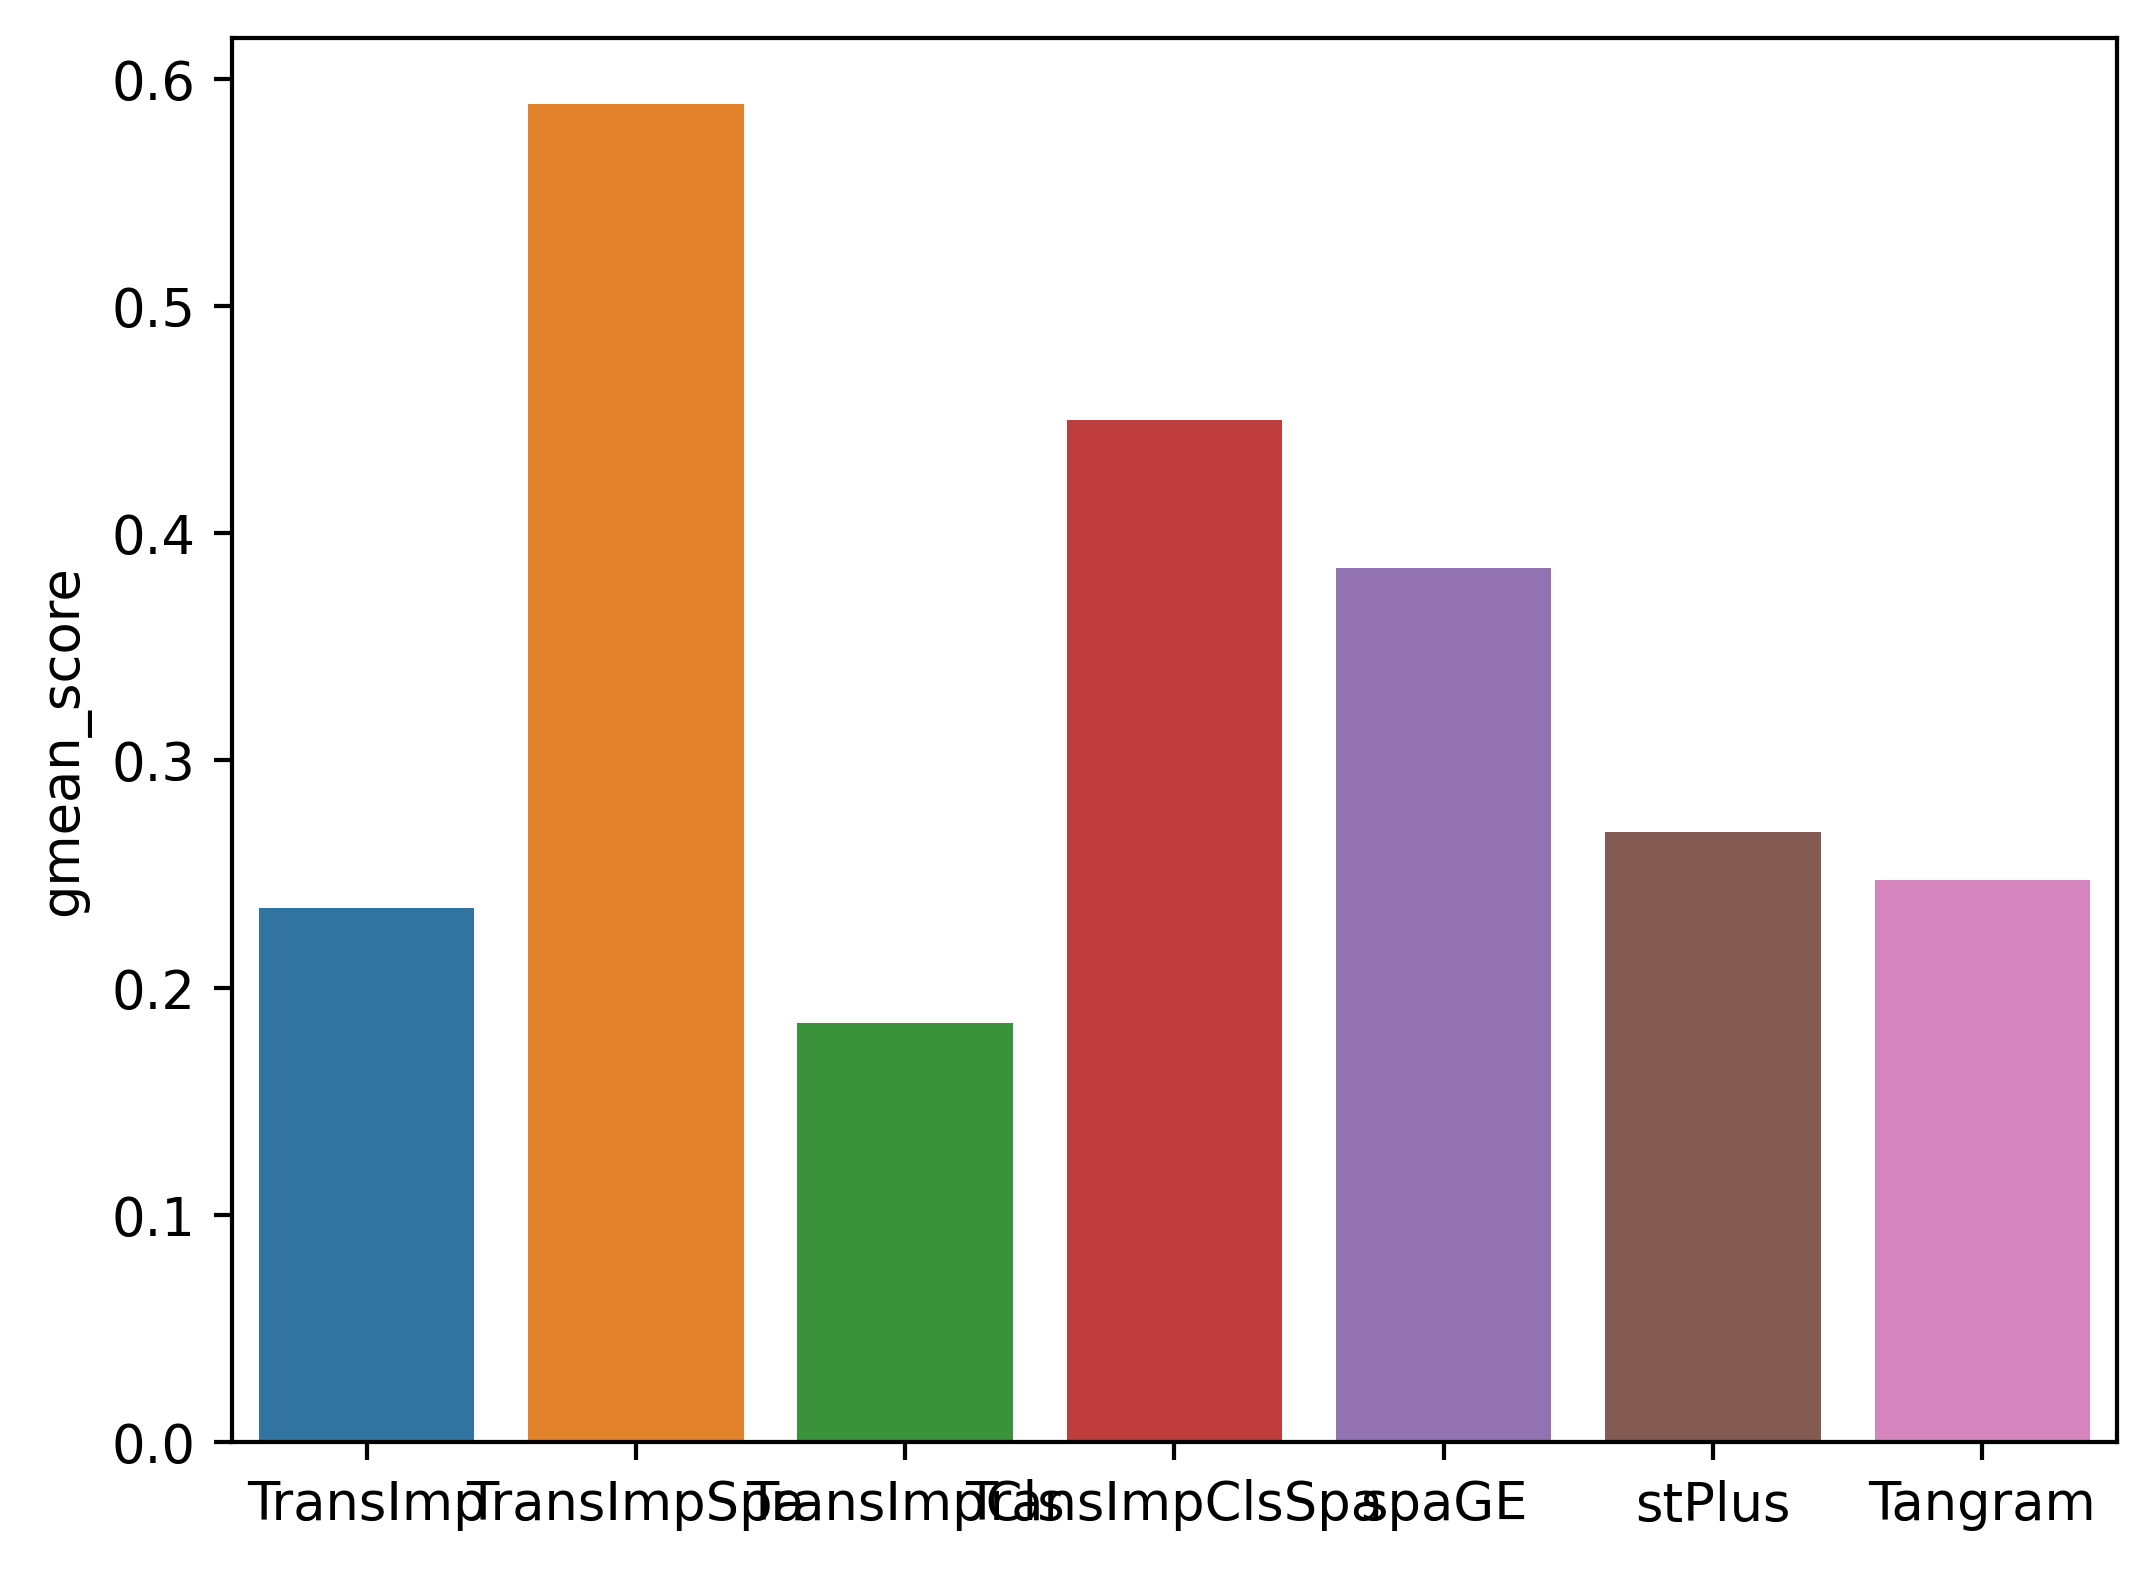

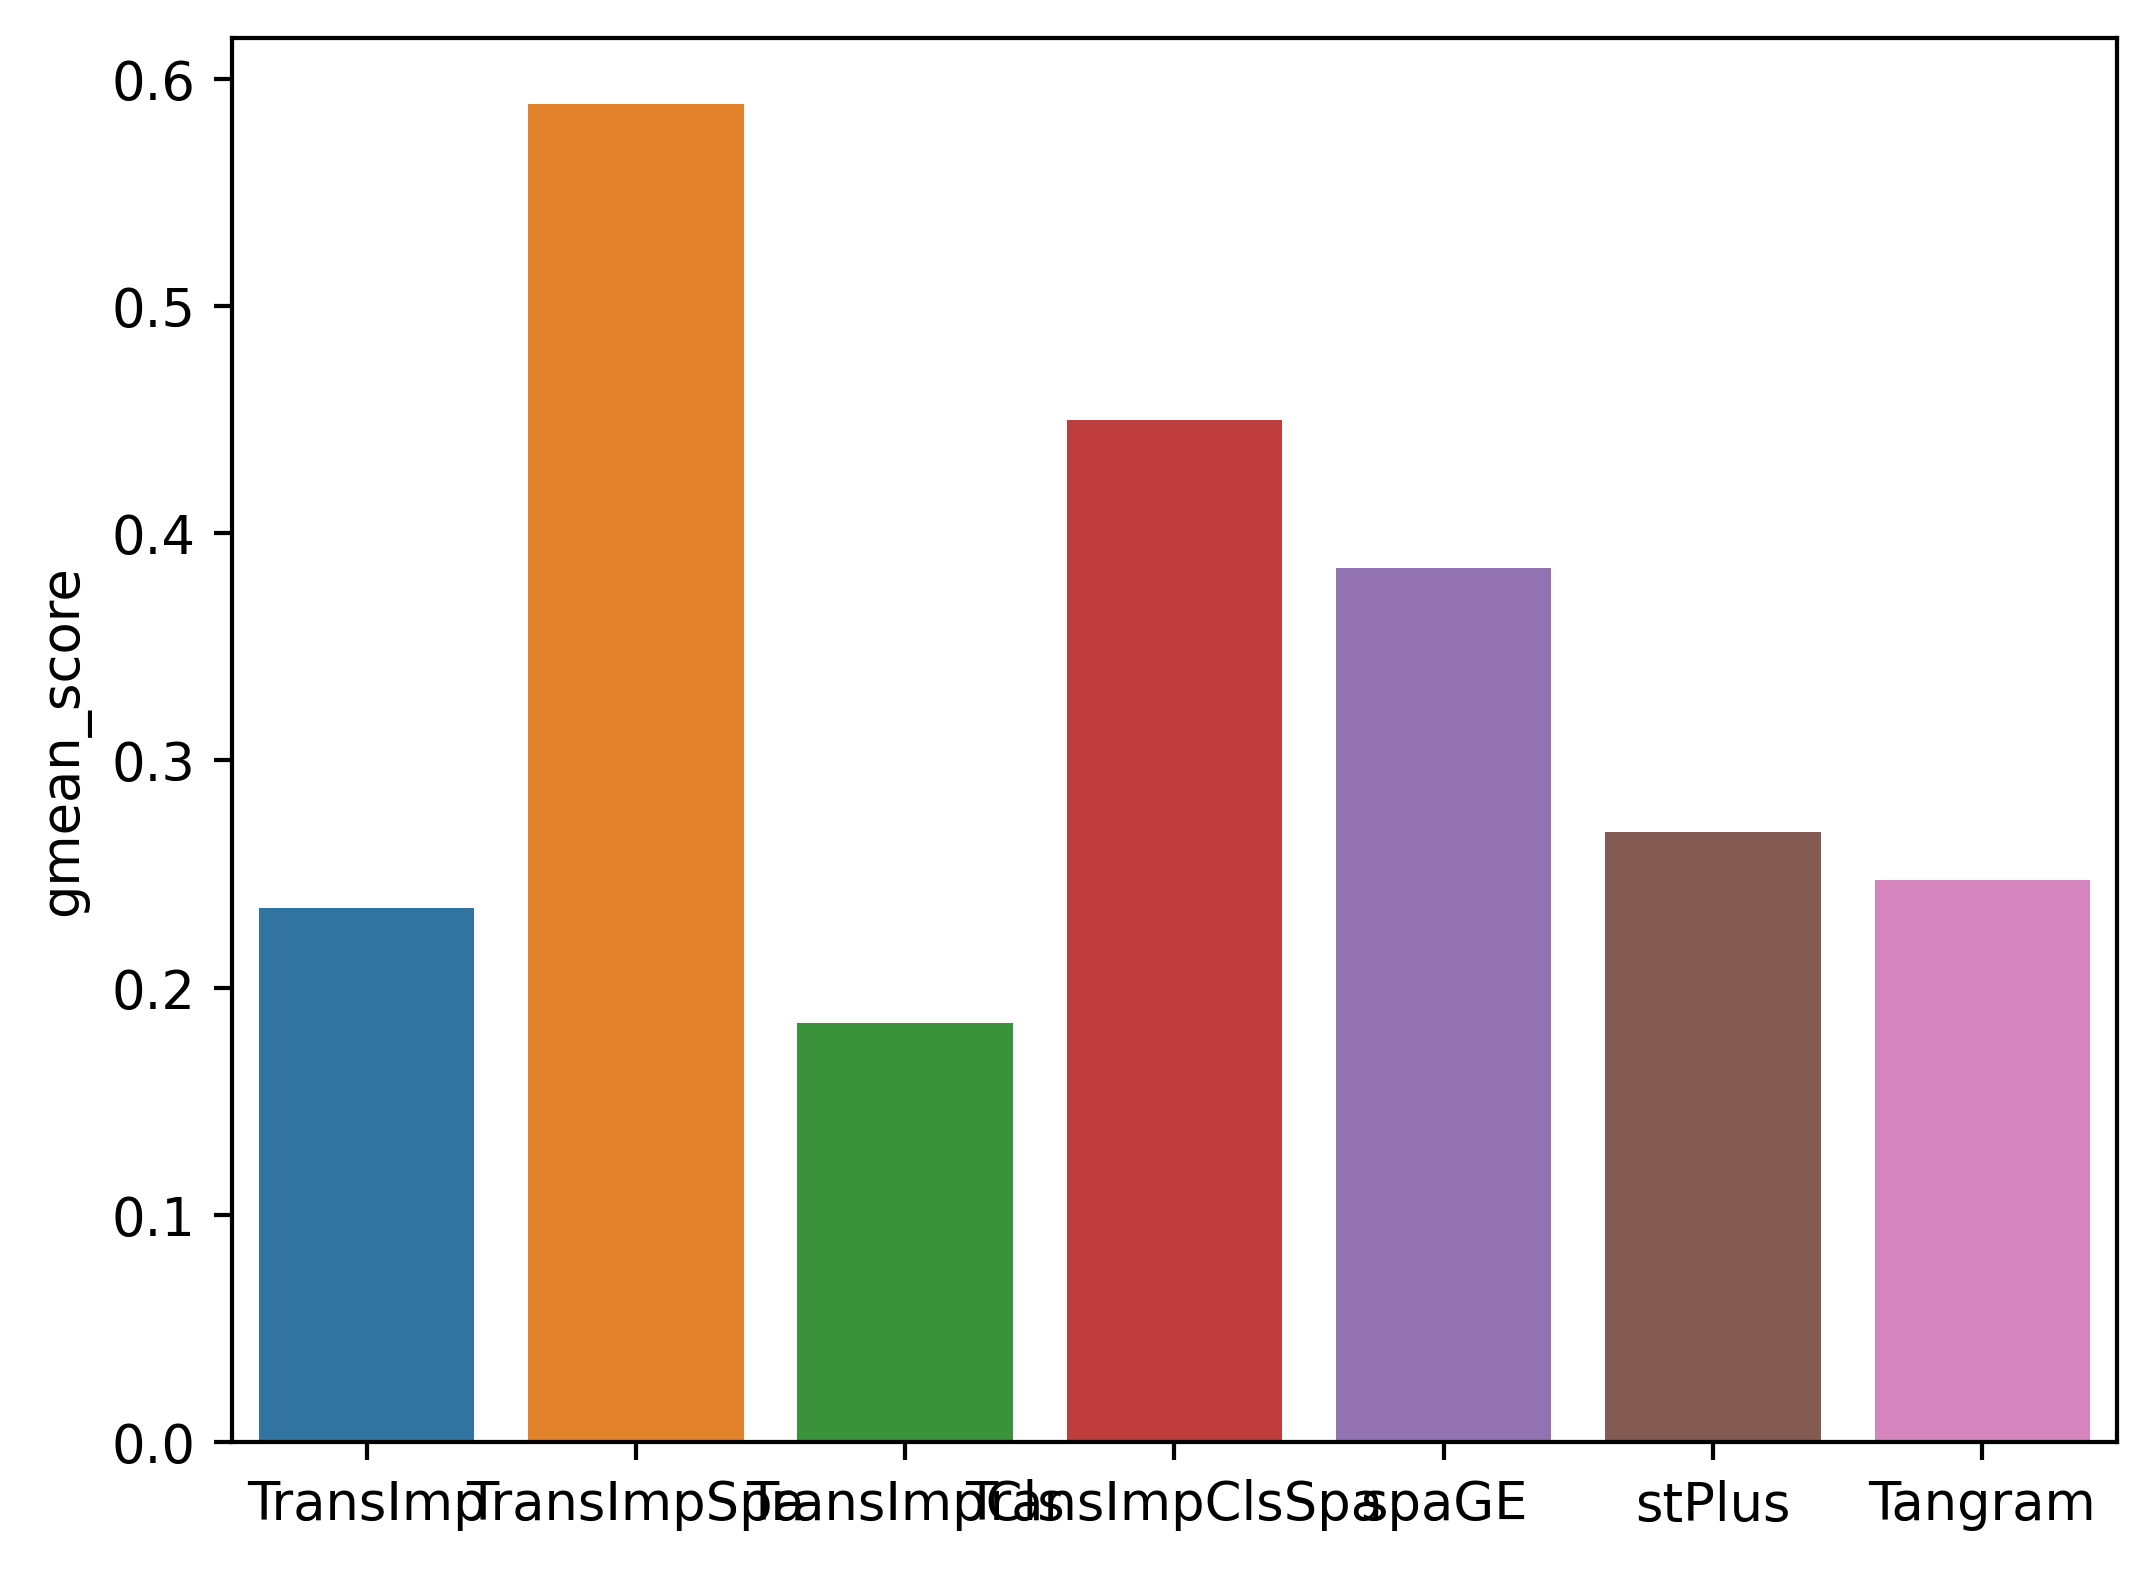

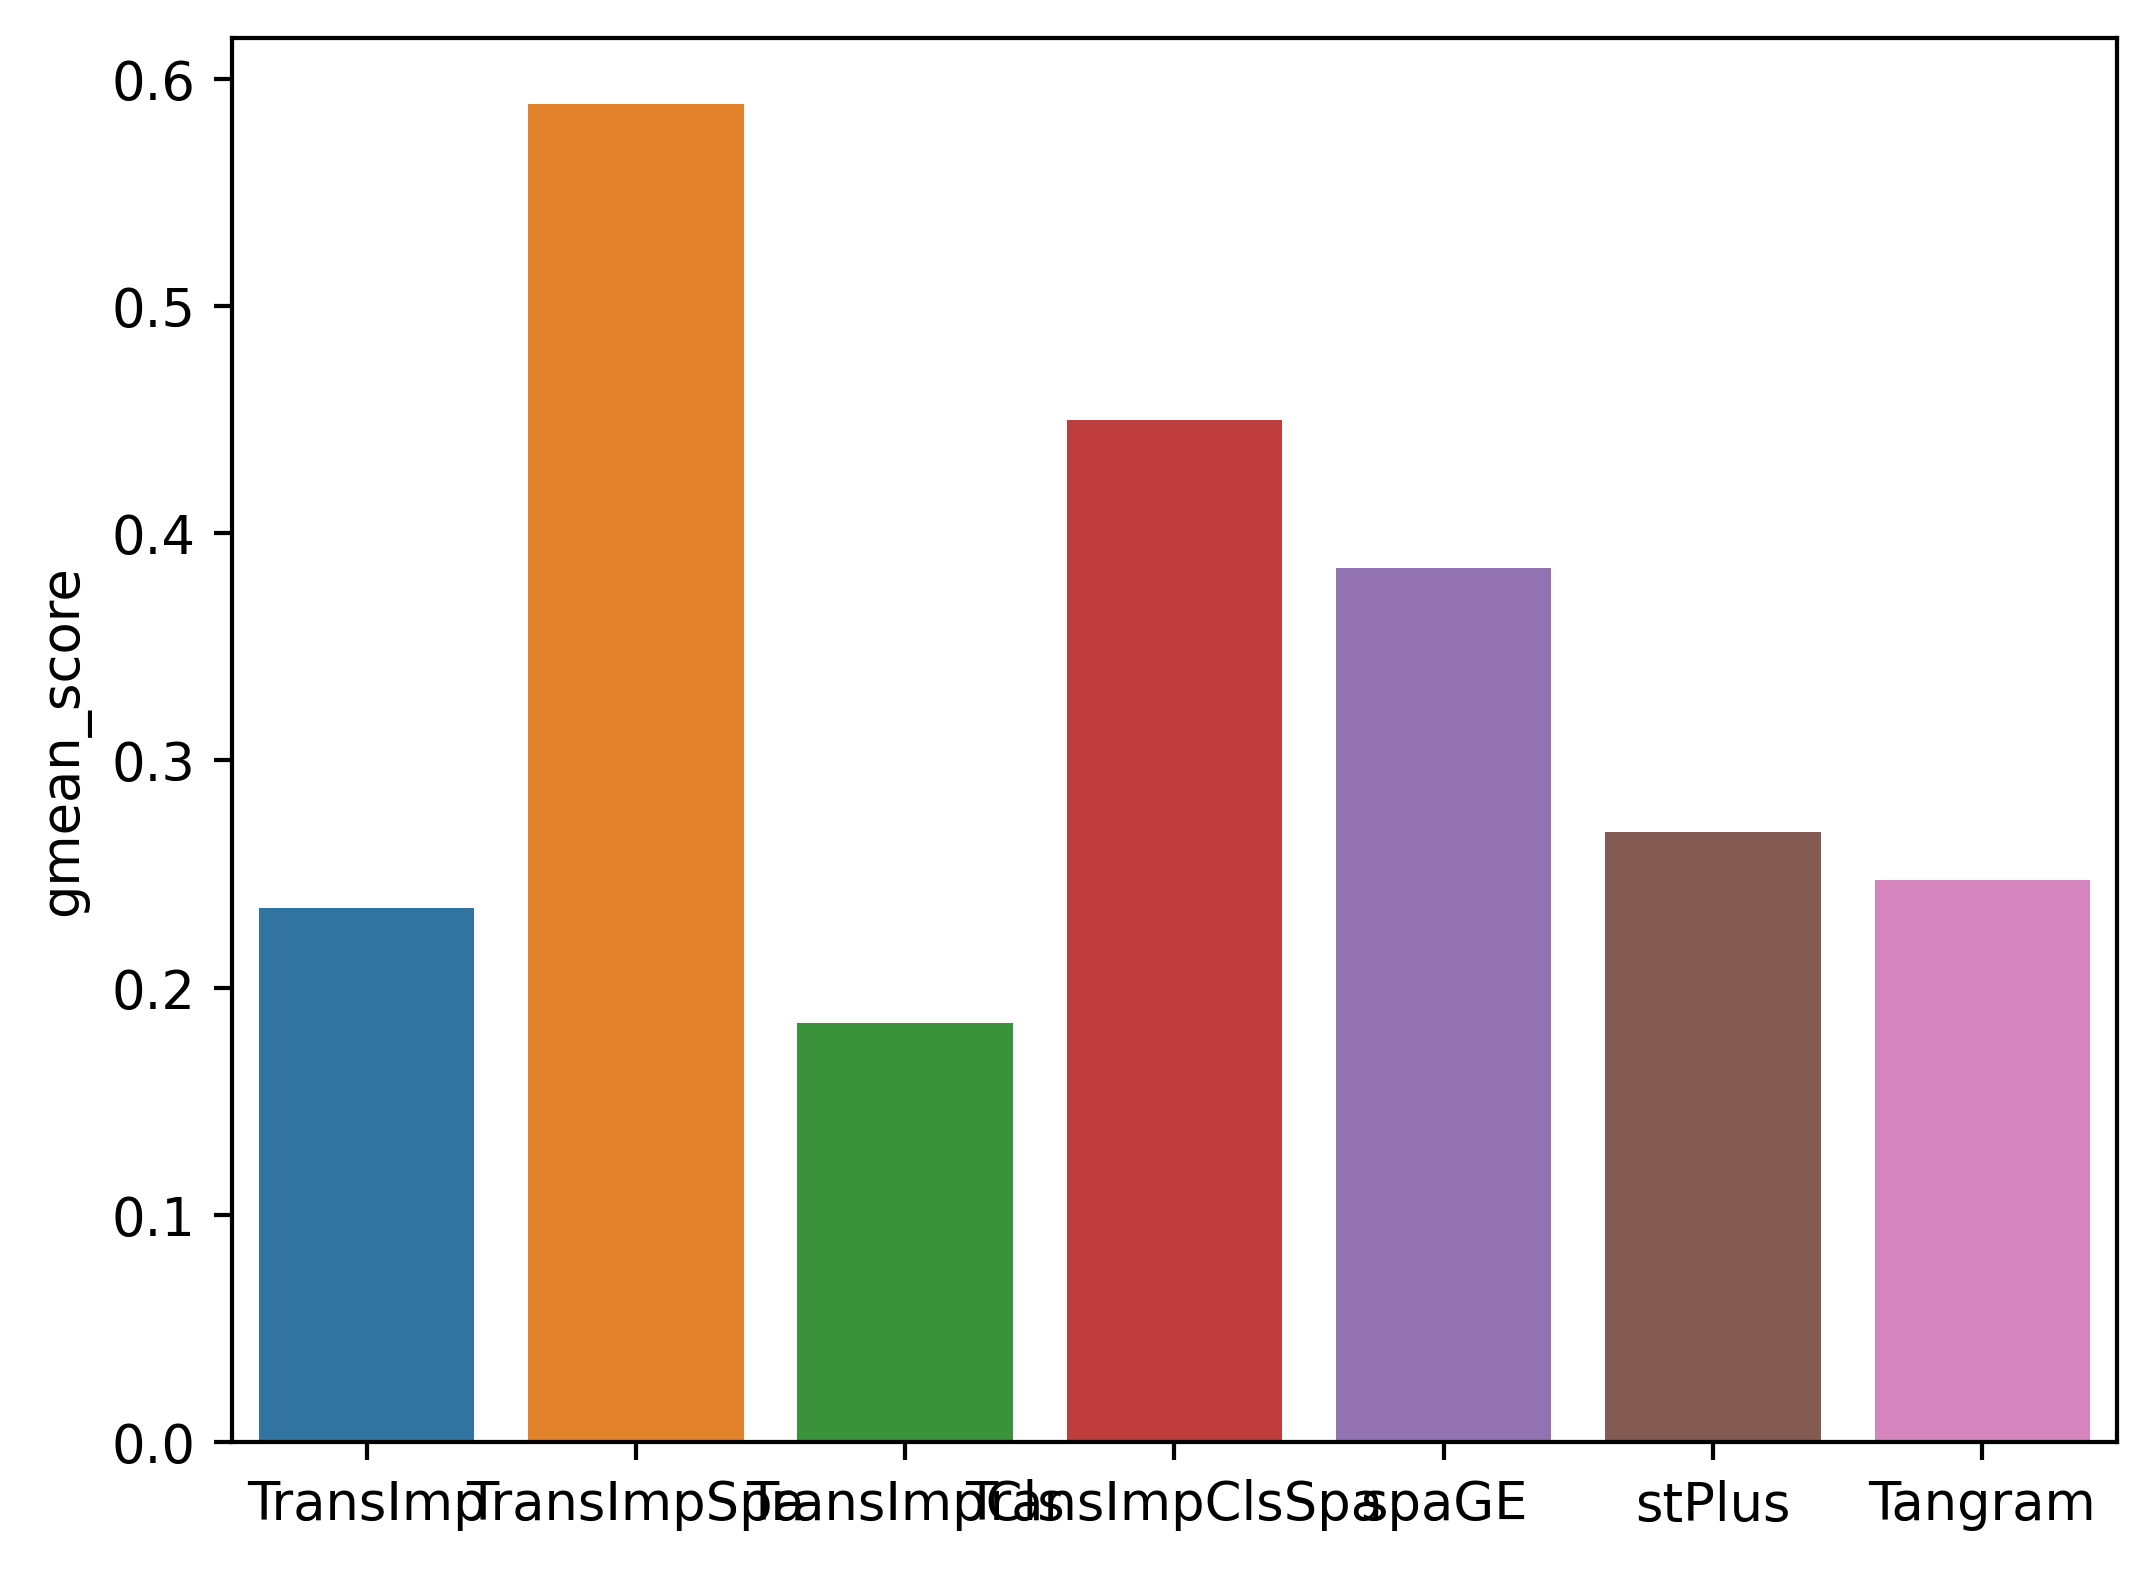

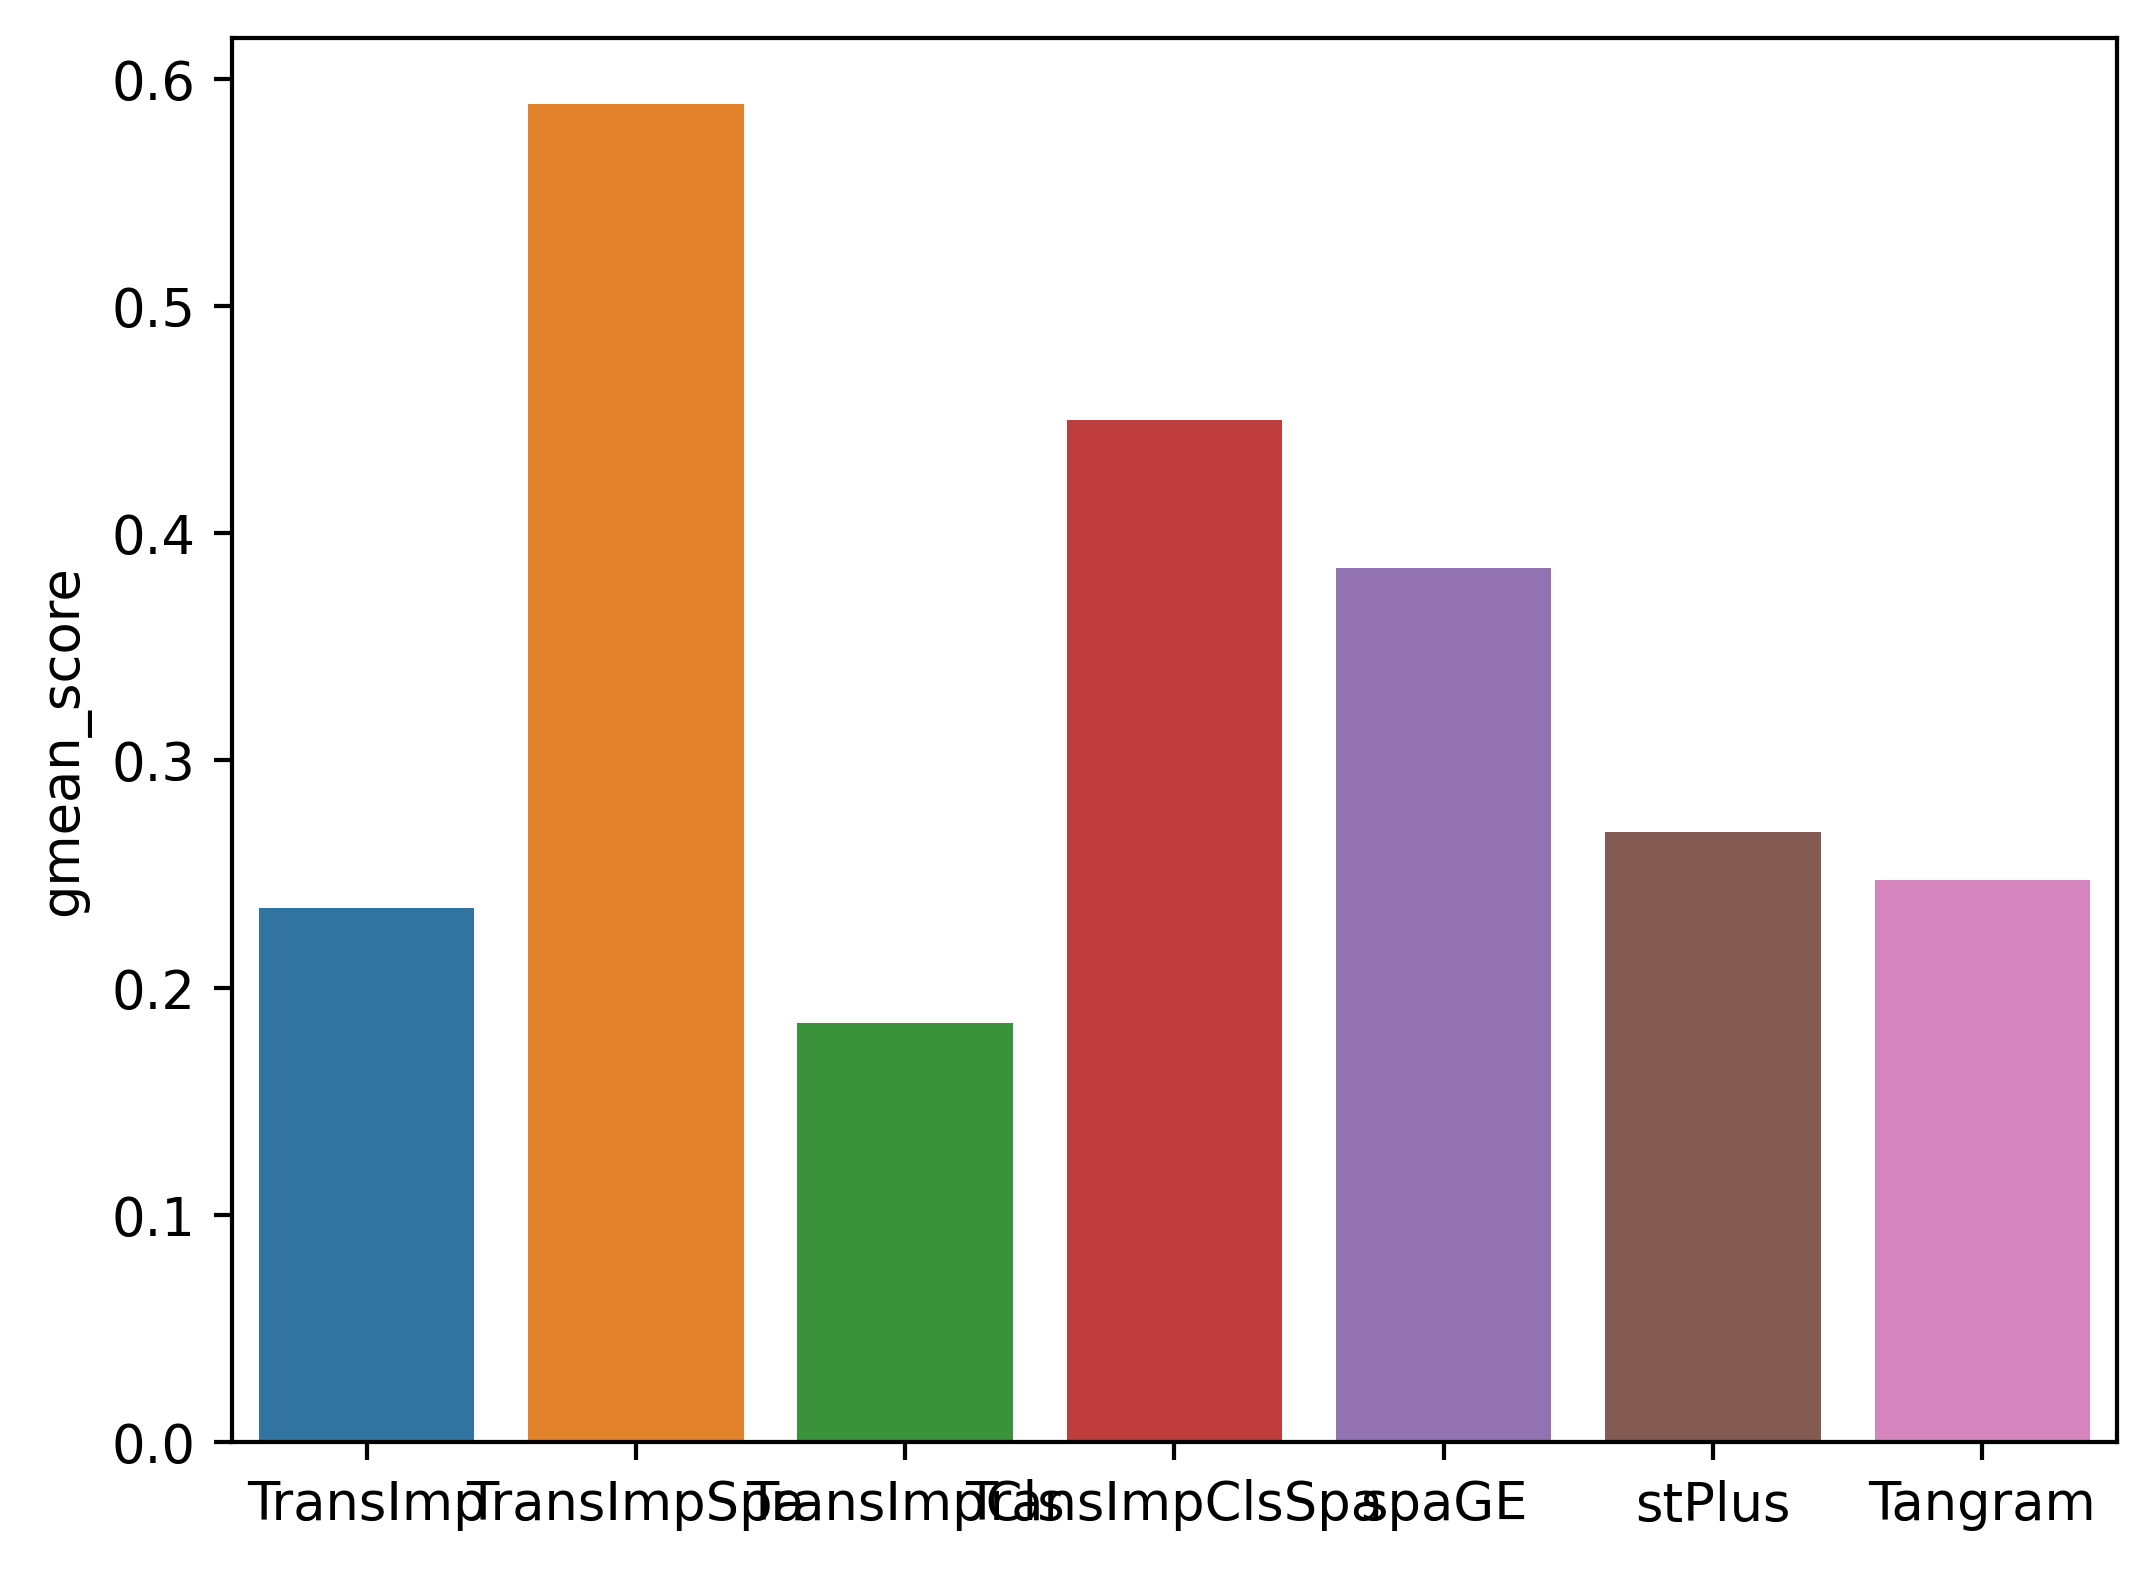

In [ ]:
import seaborn as sns

for ST_name in dict_df_res:
    dict_df_res[ST_name]['gmean_score'] = gmean(dict_df_res['melanoma5fold'][["melanoma5fold_cos_thred0.2", 
                                                                "melanoma5fold_mse_moranI", 
                                                                "melanoma5fold_mean_prec_moranI", 
                                                                "melanoma5fold_mean_prec_sparkx", 
                                                                "melanoma5fold_mean_prec_spatialdm"]], axis=1)
    plt.rcParams["figure.dpi"] = 380
    plt.rcParams.update({"font.size":12, 'axes.titlesize':30})
    sns.barplot(x=dict_df_res[ST_name].index[:-1], y=dict_df_res[ST_name]['gmean_score'][:-1] );plt.show()                                                        